In [1]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [14]:
model = load_model('/home/ubuntu/data/iceberg/results/weights/VGG16_plus_simplev2_1train_08val.h5')

In [4]:
RESULTS_DIR = '/home/ubuntu/data/iceberg/results'

In [5]:
import bcolz
def load_array(fname):
    return bcolz.open(fname)[:]

def load_precomputed_data(features_base_name="VGG16_conv_feats_with_aug/trn_"):
    filenames = load_array(RESULTS_DIR+"/"+features_base_name+'filenames.dat').tolist()
    conv_feats = load_array(RESULTS_DIR+"/"+features_base_name+'conv_feats.dat')
    labels = load_array(RESULTS_DIR+"/"+features_base_name+'labels.dat')
    return filenames, conv_feats, labels

trn_filenames, trn_conv_features, trn_labels = load_precomputed_data("VGG16_conv_feats_with_aug/trn_")
val_filenames, val_conv_features, val_labels = load_precomputed_data("VGG16_conv_feats_with_aug/val_")

In [10]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/iceberg/pngs/valid',
        target_size=(224, 224),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 400 images belonging to 2 classes.


In [14]:
predictions = model.predict(val_conv_features)

In [36]:
# is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship.
#  therefore [1,0] is a ship and [0,1] is iceberg

[ 1.  0.] [ 0.63816  0.36184]
iceberg/valid_iceberg_106.png


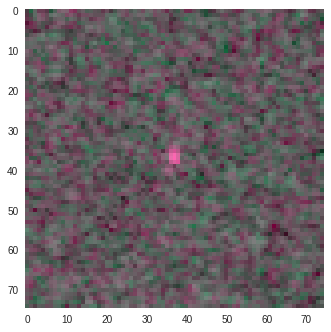

In [56]:
import imageio 
import matplotlib.pyplot as plt

img_num = 2
print(val_labels[img_num], predictions[img_num])
print(validation_generator.filenames[img_num])

base_dir = '/home/ubuntu/data/iceberg/pngs/valid/'
img = im = imageio.imread(base_dir + validation_generator.filenames[img_num])
plt.imshow(img)
plt.grid(False)
plt.show()


In [9]:
import numpy as np
import pandas as pd
import os

data_dir = '/home/ubuntu/data/iceberg'

def load_data(data_dir):
    train = pd.read_json(os.path.join(data_dir, 'train.json'))
    test = pd.read_json(os.path.join(data_dir, 'test.json'))
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)
print(train.shape, test.shape)

# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(img).astype(np.float32).reshape(75, 75) for img in df["band_1"]])
    X_band2 = np.array([np.array(img).astype(np.float32).reshape(75, 75) for img in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train_full = process_images(train)
X_test = process_images(test)

X_angle_train_full = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train_full = np.array(train["is_iceberg"])

(1604, 5) (8424, 4)


In [65]:
# Create a train and validation split, 75% of data used in training
from sklearn.model_selection import train_test_split

X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train_full,
                                    X_angle_train_full, y_train_full, random_state=6, train_size=0.75, test_size=0.25)

X_train.shape, X_valid.shape, X_angle_train.shape, X_angle_valid.shape, y_train.shape, y_valid.shape

((1203, 75, 75, 3), (401, 75, 75, 3), (1203,), (401,), (1203,), (401,))

In [69]:
%matplotlib inline

def plot_img_set(img_num):
    # randomly needs the squeeze false parameter if you only want one row of images
    f,ax = plt.subplots(1,3,figsize=(20,10), squeeze=False)
    ax[0][0].imshow(X_valid[img_num, :, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(X_valid[img_num, :, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(X_valid[img_num, :, :,2]), ax[0][2].set_title("avg band1,2")
    

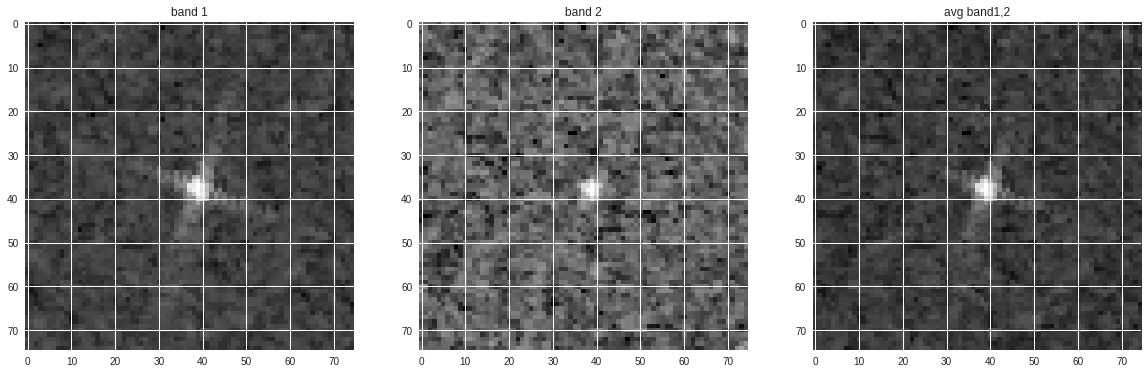

In [76]:
img_num = 
plot_img_set(img_num)

[ 1.  0.] [ 1.  0.]
iceberg/valid_iceberg_130.png


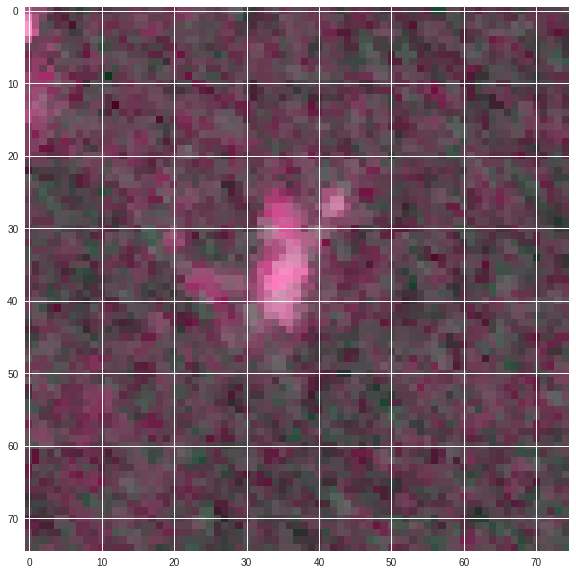

In [85]:
img_num = 8
print(val_labels[img_num], predictions[img_num])
print(validation_generator.filenames[img_num])

plt.figure(figsize=(20,10))
base_dir = '/home/ubuntu/data/iceberg/pngs/valid/'
img = imageio.imread(base_dir + validation_generator.filenames[img_num])
plt.imshow(img)
# plt.grid(False)
plt.show()

In [192]:
for i in range(len(validation_generator.filenames)):
    test = str(i) + ':' + str(predictions[i]) + ',' + str(val_labels[i]) + validation_generator.filenames[i] 
    print(test)

0:[ 0.99679  0.00321],[ 1.  0.]iceberg/valid_iceberg_0.png
1:[ 0.99626  0.00374],[ 1.  0.]iceberg/valid_iceberg_100.png
2:[ 0.63816  0.36184],[ 1.  0.]iceberg/valid_iceberg_106.png
3:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_108.png
4:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_109.png
5:[ 0.24387  0.75613],[ 1.  0.]iceberg/valid_iceberg_111.png
6:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_122.png
7:[ 0.00411  0.99589],[ 1.  0.]iceberg/valid_iceberg_123.png
8:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_130.png
9:[ 1.  0.],[ 1.  0.]iceberg/valid_iceberg_131.png
10:[ 0.98365  0.01635],[ 1.  0.]iceberg/valid_iceberg_132.png
11:[ 0.27952  0.72048],[ 1.  0.]iceberg/valid_iceberg_133.png
12:[ 0.99973  0.00027],[ 1.  0.]iceberg/valid_iceberg_134.png
13:[ 0.99968  0.00032],[ 1.  0.]iceberg/valid_iceberg_135.png
14:[ 0.99682  0.00318],[ 1.  0.]iceberg/valid_iceberg_138.png
15:[ 0.99912  0.00088],[ 1.  0.]iceberg/valid_iceberg_139.png
16:[ 0.00006  0.99994],[ 1.  0.]iceberg/valid_iceberg_14.png
17:[ 0.  

In [219]:
def plot_img_set(img_num, img_num2, img_num3):
    
    f,ax = plt.subplots(3,3,figsize=(30,30), squeeze=False)
    # randomly needs the squeeze false parameter if you only want one row of images
    img = imageio.imread(base_dir + validation_generator.filenames[img_num])

    ax[0][0].imshow(img[:, :,0]), ax[0][0].set_title("band 1")
    ax[0][1].imshow(img[:, :,1]), ax[0][1].set_title("band 2")
    ax[0][2].imshow(img[:, :,2]), ax[0][2].set_title("avg band1,2")
    print(validation_generator.filenames[img_num])
    print(val_labels[img_num], predictions[img_num])
    print('max: ',img[:,:,0].max(), img[:,:,1].max(), img[:,:,2].max(),' | min: ',img[:,:,0].min(), img[:,:,1].min(), img[:,:,2].min(), ' | mean: ',img[:,:,0].mean(), img[:,:,1].mean(), img[:,:,2].mean())
 
    img2 = imageio.imread(base_dir + validation_generator.filenames[img_num2])
    ax[1][0].imshow(img2[:, :,0]), ax[1][0].set_title("band 1")
    ax[1][1].imshow(img2[:, :,1]), ax[1][1].set_title("band 2")
    ax[1][2].imshow(img2[:, :,2]), ax[1][2].set_title("avg band1,2")
    print(validation_generator.filenames[img_num2])
    print(val_labels[img_num2], predictions[img_num2])
    print('max: ',img2[:,:,0].max(), img2[:,:,1].max(), img2[:,:,2].max(),' | min: ',img2[:,:,0].min(), img2[:,:,1].min(), img2[:,:,2].min(), ' | mean: ',img2[:,:,0].mean(), img2[:,:,1].mean(), img2[:,:,2].mean())
                 
    img3 = imageio.imread(base_dir + validation_generator.filenames[img_num3])
    ax[2][0].imshow(img3[:, :,0]), ax[2][0].set_title("band 1")
    ax[2][1].imshow(img3[:, :,1]), ax[2][1].set_title("band 2")
    ax[2][2].imshow(img3[:, :,2]), ax[2][2].set_title("avg band1,2")
    print(validation_generator.filenames[img_num3])
    print(val_labels[img_num3], predictions[img_num3])
    print('max: ',img3[:,:,0].max(), img3[:,:,1].max(), img3[:,:,2].max(),' | min: ', img3[:,:,0].min(), img3[:,:,1].min(), img3[:,:,2].min(), ' | mean: ', img3[:,:,0].mean(), img3[:,:,1].mean(), img3[:,:,2].mean())
       

no_ice/valid_no_ice_326.png
[ 0.  1.] [ 0.8715  0.1285]
max:  254 186 220  | min:  45 0 60  | mean:  158.305066667 93.6432 125.976
no_ice/valid_no_ice_329.png
[ 0.  1.] [ 0.99432  0.00568]
max:  255 171 192  | min:  20 0 40  | mean:  121.040177778 103.303466667 112.139555556
no_ice/valid_no_ice_34.png
[ 0.  1.] [ 0.75256  0.24744]
max:  255 117 181  | min:  0 0 24  | mean:  72.0190222222 64.0264888889 68.0716444444


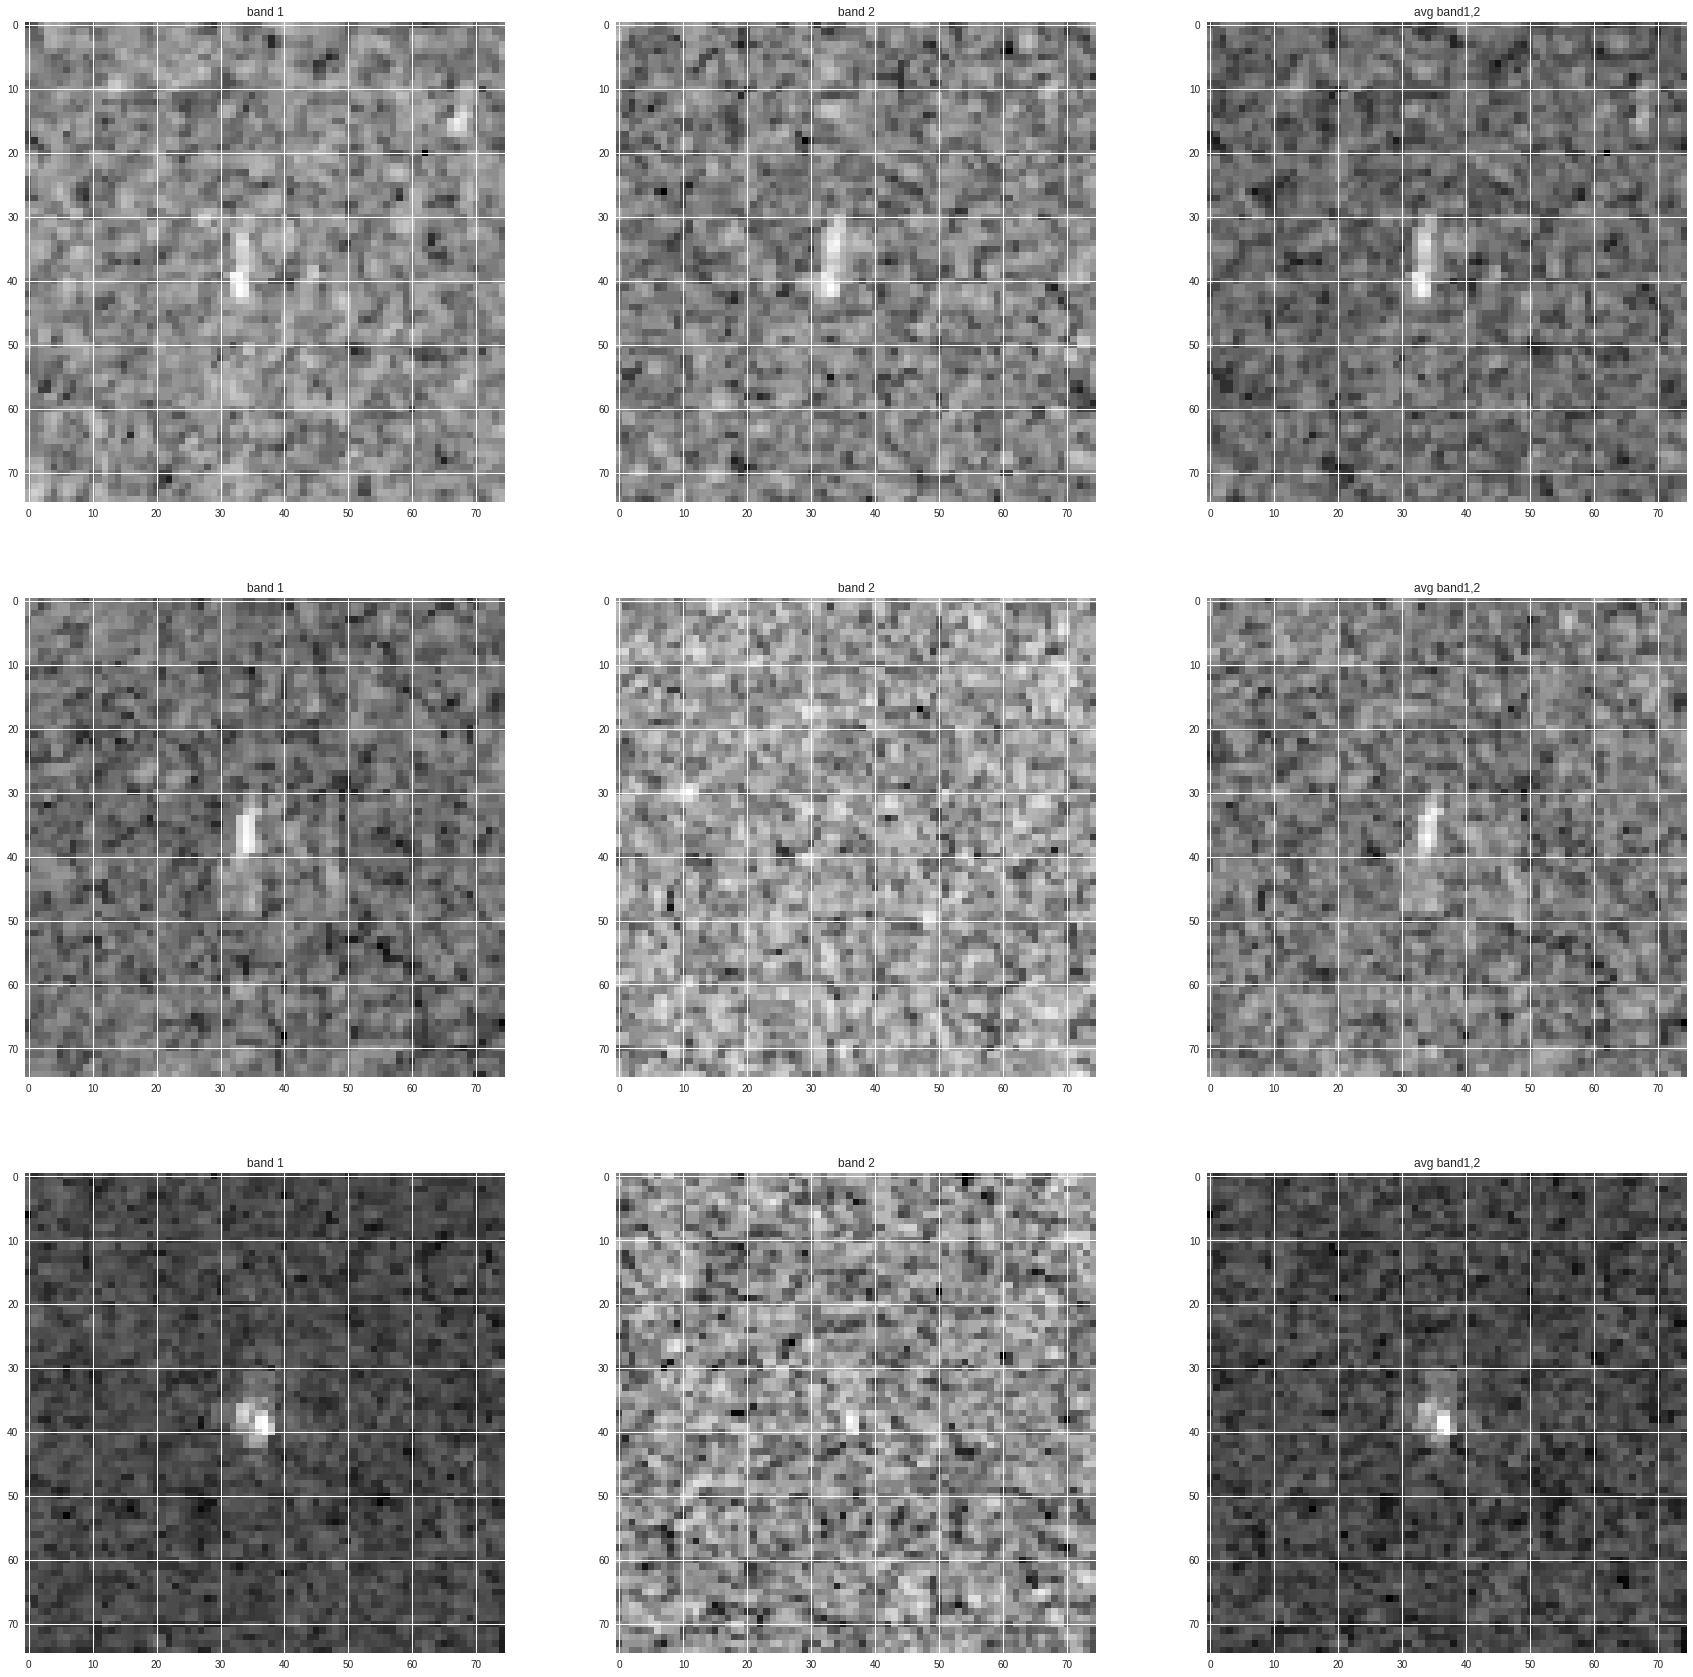

In [224]:
plot_img_set(322,323,326)

In [226]:
submit_nums = np.clip(predictions, 0.1, 0.9, out=predictions)

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

vgg_base = VGG16(weights='imagenet', include_top=False)

In [10]:
X_test.shape

(8424, 75, 75, 3)

In [11]:
generator = test_datagen.flow(
        X_test,
        batch_size=32,
        shuffle=False)

In [12]:
conv_features = vgg_base.predict_generator(generator, (generator.n/generator.batch_size))

In [15]:
test_preds = model.predict(conv_features)

ValueError: Error when checking : expected input_2 to have shape (None, 7, 7, 512) but got array with shape (8424, 2, 2, 512)

In [16]:
# above is wrong some how, need to figure this out for the prediction - end of day now